# Índice

1. [Herramientas para la Manipulación y Análisis de Datos](#herramientas-para-la-manipulación-y-analisis-de-datos)
2. [Carga del Conjunto de Datos](#carga-del-conjunto-de-datos)
3. [Identificación de Valores Nulos Iniciales](#identificacion-de-valores-nulos-iniciales)
4. [Rango Intercuartílico (IQR)](#Rango-Intercuartílico-(IQR))
5. [Tramatamiento de los datos](#Tramatamiento-de-los-datos)
6. [Definición de Predictores y Objetivos](#Definición-de-Predictores-y-Objetivos)
7. [Normalización y Separación de los Datos](#Normalización-y-Separación-de-los-Datos)
8. [Definición y Configuración de los Modelos](#Definición-y-Configuración-de-los-Modelos)
9. [Optimización, Evaluación y Comparación de Modelos](#optimización-evaluación-y-comparación-de-modelos)
10. [Conversión de Resultados a un DataFrame](#Conversión-de-Resultados-a-un-DataFrame)
11. [Conclusión final](#Conclusión-final)


## **Importaciones**

### Bibliotecas para manejo de datos y análisis exploratorio
- **Pandas**: Biblioteca utilizada para manipulación y análisis de datos estructurados, como tablas. Facilita tareas como lectura, limpieza y transformación de datos.
- **NumPy**: Herramienta para realizar cálculos numéricos de alto rendimiento, incluyendo manejo eficiente de arrays y operaciones matemáticas avanzadas.
- **Seaborn**: Biblioteca especializada en la visualización de datos estadísticos. Permite crear gráficos claros y atractivos que ayudan a entender patrones en los datos.
- **Matplotlib.pyplot**: Proporciona funciones para generar gráficos personalizados y detallados, muy útiles para análisis exploratorios.

### Preprocesamiento y escalado de datos
- **MinMaxScaler**: Técnica de normalización que ajusta los valores de las variables a un rango específico, generalmente entre 0 y 1. Esto es especialmente útil para algoritmos sensibles a la escala de los datos.

### División de datos y validación
- **Train-Test Split**: Método para dividir los datos en conjuntos de entrenamiento y prueba. Ayuda a evaluar el rendimiento de los modelos y evita problemas como el sobreajuste.
- **GridSearchCV**: Herramienta para buscar automáticamente los mejores hiperparámetros de un modelo mediante validación cruzada. Esto optimiza el desempeño de los algoritmos.

### Modelos de regresión
- **Regresión Lineal**: Modelo utilizado para capturar relaciones lineales entre variables independientes y dependientes.
- **Árbol de Decisión**: Modelo basado en una estructura jerárquica que divide los datos en subconjuntos según reglas simples, lo que permite capturar relaciones no lineales.
- **Random Forest**: Un algoritmo de ensamblado que combina múltiples árboles de decisión para mejorar la precisión y la estabilidad de las predicciones.
- **Gradient Boosting**: Técnica de aprendizaje en la que se entrenan modelos en secuencia, enfocándose en corregir los errores de los modelos anteriores.
- **SVR (Máquinas de Soporte Vectorial)**: Modelo que encuentra un hiperplano en un espacio de alta dimensión para realizar predicciones.
- **XGBoost**: Una implementación eficiente y rápida de Gradient Boosting, popular por su capacidad de manejar grandes conjuntos de datos y características complejas.
- **Regresión con Redes Neuronales**: Modelo basado en redes neuronales artificiales, útil para capturar patrones complejos y no lineales en los datos.

### Métricas de evaluación
- **Errores Absoluto y Cuadrático Medio**: Métricas para medir la diferencia entre los valores predichos y los valores reales. Se utilizan para evaluar la precisión de los modelos.
- **Varianza Explicada y Coeficiente de Determinación (R²)**: Métricas que indican qué tan bien un modelo explica la variabilidad de los datos.

### Estadística y control de calidad
- **Z-Score**: Método estadístico que mide cuántos desvíos estándar se encuentra un valor respecto a la media. Ayuda a detectar valores atípicos.

### Configuración adicional
- **Warnings**: Se desactivan las advertencias para evitar mensajes innecesarios durante la ejecución, lo que hace que el flujo de trabajo sea más limpio.


In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from scipy.stats import zscore
import warnings
warnings.filterwarnings("ignore")


## **Preprocesamiento de datos**

### Carga inicial de los datos
- Se cargan los datos desde un archivo CSV utilizando la función `read_csv` de Pandas. 
- El delimitador utilizado en el archivo es el punto y coma (`;`), ya que es común en ciertos formatos de datos internacionales.

### Conversión de valores numéricos
- Se identifican columnas específicas con valores numéricos que están representados con comas (`','`) en lugar de puntos (`'.'`).
- Se reemplazan las comas por puntos y las columnas se convierten al tipo `float` para su correcto manejo en operaciones matemáticas y análisis.

### Conversión de valores flotantes a enteros
- Se revisan las columnas numéricas para verificar si contienen únicamente valores enteros. Si no hay decimales (es decir, si los valores son múltiplos exactos de 1), estas columnas se convierten al tipo `Int64` para optimizar el uso de memoria y mejorar la claridad.

### Configuración de formato en Pandas
- Se establece una configuración global para que los números flotantes no muestren decimales en las salidas de Pandas. Esto mejora la legibilidad cuando los valores no necesitan decimales.

### Eliminación de columnas innecesarias
- Se eliminan columnas irrelevantes para el análisis, como aquellas que no aportan información útil (por ejemplo, columnas con valores vacíos o relacionadas con fechas y tiempos si no son necesarias).
- La opción `errors='ignore'` garantiza que el código no falle si alguna columna especificada ya no está presente en el conjunto de datos.

Este proceso garantiza que los datos estén en un formato limpio, consistente y adecuado para el análisis posterior.


In [11]:
# Cargar los datos
df = pd.read_csv('data/AirQuality.csv', delimiter=';')

# Reemplazar comas por puntos y convertir columnas a float
columns_to_convert = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_convert:
    df[col] = df[col].str.replace(',', '.', regex=False).astype(float)

# Convertir todas las columnas numéricas a enteros si no tienen decimales
for col in df.select_dtypes(include=['float', 'int']).columns:
    if df[col].dropna().mod(1).eq(0).all():  # Verifica si todos los valores son enteros
        df[col] = df[col].astype('Int64')  # Convierte a entero compatible con NaN

# Configuración para que no muestre decimales en pandas
pd.set_option('display.float_format', '{:.0f}'.format)

# Eliminar columnas innecesarias
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16', 'Time','Mes','Anio','dia','diaSemana','Date'], errors='ignore')

## **Manejo de valores nulos**

### Contar valores nulos antes de la eliminación
- Antes de realizar cualquier operación de limpieza, se cuenta la cantidad de valores nulos (`NaN`) presentes en cada columna del conjunto de datos.
- Esto proporciona una visión general del estado inicial del dataset y ayuda a decidir las estrategias de limpieza necesarias.

### Eliminación de filas completamente nulas
- Se eliminan todas las filas donde **todos los valores**, incluyendo el índice, sean nulos.
- Este enfoque asegura que las filas vacías no interfieran con el análisis y procesamiento de los datos.

### Contar valores nulos después de la eliminación
- Tras la eliminación de filas completamente nulas, se realiza un nuevo conteo de valores nulos en cada columna para verificar los cambios en el conjunto de datos.
- Este paso permite validar que la operación de limpieza se realizó correctamente.

### Información sobre el estado del dataset limpio
- **Tipos de datos**: Se revisan los tipos de datos de cada columna después de la limpieza para garantizar que son apropiados para el análisis posterior.
- **Primeros registros**: Se imprimen los primeros registros del dataset limpio para confirmar visualmente que los datos restantes están en un formato adecuado.

Este procedimiento es esencial para garantizar que los datos sean consistentes y estén listos para las siguientes etapas del análisis o modelado.


In [12]:
# Contar valores nulos antes de la eliminación
valores_nulos = df.isna().sum()
print("Valores nulos antes de la eliminación:")
print(valores_nulos)

# Eliminar filas donde todos los valores, incluyendo el índice, sean NaN
df_cleaned = df.dropna()

# Contar valores nulos después de la eliminación
valores_nulos_despues = df_cleaned.isna().sum()
print("\nValores nulos después de la eliminación:")
print(valores_nulos_despues)

# Mostrar información y primeros registros
print("\nTipos de datos después de la limpieza:")
print(df_cleaned.dtypes)
print("\nPrimeros registros después de la limpieza:")
print(df_cleaned.head())

Valores nulos antes de la eliminación:
CO(GT)           114
PT08.S1(CO)      114
NMHC(GT)         114
C6H6(GT)         114
PT08.S2(NMHC)    114
NOx(GT)          114
PT08.S3(NOx)     114
NO2(GT)          114
PT08.S4(NO2)     114
PT08.S5(O3)      114
T                114
RH               114
AH               114
dtype: int64

Valores nulos después de la eliminación:
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

Tipos de datos después de la limpieza:
CO(GT)           float64
PT08.S1(CO)        Int64
NMHC(GT)           Int64
C6H6(GT)         float64
PT08.S2(NMHC)      Int64
NOx(GT)            Int64
PT08.S3(NOx)       Int64
NO2(GT)            Int64
PT08.S4(NO2)       Int64
PT08.S5(O3)        Int64
T                float64
RH               float64
AH               float64
dtype: o

## **Matriz de Correlación**

La matriz de correlación se utiliza para identificar relaciones lineales entre las variables del conjunto de datos. Es una herramienta clave para:
- Detectar patrones en los datos.
- Identificar variables altamente correlacionadas que pueden ser redundantes o aportar información relevante para el modelado.
- Ayuda a seleccionar características relevantes para el modelado al identificar variables que están altamente correlacionadas con el objetivo.
- Permite detectar posibles problemas de multicolinealidad cuando dos o más variables independientes están altamente correlacionadas entre sí.

### Pasos
1. **Tamaño de la figura**:
   - Se configura un tamaño específico para la visualización (12 x 10 pulgadas) para garantizar que todos los valores y etiquetas sean legibles.

2. **Heatmap de correlación**:
   - Se utiliza `sns.heatmap` para crear un mapa de calor que visualiza las correlaciones entre todas las variables numéricas del dataset.
   - Las correlaciones se calculan con el método de Pearson, que mide la relación lineal entre dos variables.

3. **Anotaciones**:
   - Los valores de correlación se anotan directamente en el mapa para facilitar su interpretación. 
   - El formato se ajusta a dos decimales (`fmt=".2f"`) para mayor claridad.

4. **Colores del mapa**:
    La matriz de correlación muestra las relaciones lineales entre las diferentes variables del conjunto de datos. Los valores de correlación oscilan entre -1 y 1:
    - **1**: Correlación positiva perfecta.
    - **0**: Sin correlación.
    - **-1**: Correlación negativa perfecta.

    Los colores en el mapa de calor ayudan a interpretar visualmente la intensidad y la dirección de las relaciones:
    - **Azul intenso**: Indica una fuerte correlación negativa.
    - **Rojo intenso**: Indica una fuerte correlación positiva.
    - **Blanco**: Representa poca o ninguna correlación.

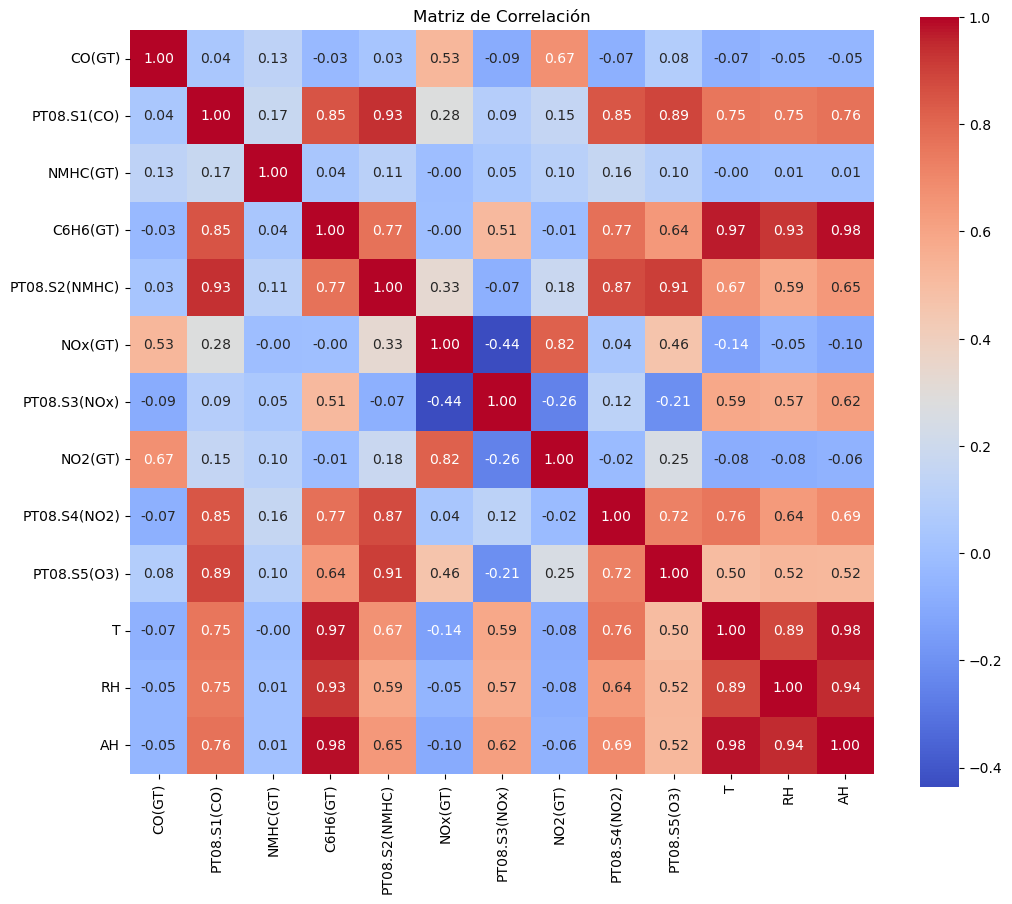

In [13]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matriz de Correlación")
plt.show()

### **Análisis de la Matriz de Correlación**

## Observaciones destacadas
1. **Variables altamente correlacionadas**:
   - `C6H6(GT)` muestra una correlación **muy alta** (valores cercanos a 1) con las variables:
     - `PT08.S2(NMHC)` (**0.91**).
     - `PT08.S4(NO2)` (**0.87**).
     - `PT08.S1(CO)` (**0.85**).
   - Estas relaciones sugieren que estas variables pueden estar relacionadas de manera directa o compartir un patrón común.

2. **Correlaciones negativas**:
   - `NOx(GT)` tiene una correlación **negativa moderada** con:
     - `PT08.S4(NO2)` (**-0.44**).
     - `PT08.S3(NOx)` (**-0.44**).
   - Esto podría indicar que estas variables tienen relaciones inversas en ciertos contextos físicos.

3. **Variables relacionadas con la humedad (`RH`) y temperatura (`T`)**:
   - `T` (temperatura) y `AH` (humedad absoluta) están **altamente correlacionadas** (**0.98**), lo cual es esperado, ya que la temperatura influye directamente en la cantidad de humedad que puede retener el aire.
   - `RH` (humedad relativa) también tiene una correlación alta con `AH` (**0.94**) y `T` (**0.89**).

4. **Relaciones con contaminantes específicos**:
   - `CO(GT)` tiene una correlación moderada con `NO2(GT)` (**0.67**), lo que sugiere que los niveles de CO y NO2 podrían estar relacionados por fuentes comunes, como emisiones de vehículos.


## Interpretación para el modelado
- Las variables con **alta correlación positiva o negativa** pueden indicar redundancia, por lo que es importante evaluar si todas son necesarias para el modelo.
- Las variables con correlación cercana a **0** (poca relación) pueden ser menos útiles para modelos predictivos relacionados con otras variables objetivo.
- Antes de usar estas variables en un modelo de regresión o aprendizaje automático, se debe considerar:
  - La eliminación de variables altamente correlacionadas para evitar problemas de multicolinealidad.
  - La selección de las variables más relevantes basándose en el contexto del análisis.

# Detección de Outliers con el Rango Intercuartílico (IQR)
Los valores atípicos (outliers) son puntos de datos que se desvían significativamente del resto de las observaciones en un conjunto de datos. Detectarlos es crucial, ya que pueden afectar la precisión de los modelos predictivos y distorsionar los análisis estadísticos.

Este análisis utiliza el rango intercuartílico (IQR) para identificar valores atípicos. El IQR es la diferencia entre el tercer cuartil (Q3, el 75%) y el primer cuartil (Q1, el 25%), lo que representa el rango central de los datos.

## Proceso

1. **Definición de la función para detectar outliers**:
   - Para cada columna numérica:
     - Se calcula el primer cuartil (Q1, 25%) y el tercer cuartil (Q3, 75%).
     - Se calcula el rango intercuartílico (IQR) como la diferencia entre Q3 y Q1.
     - Se determinan los límites inferior y superior para identificar outliers:
       - **Límite inferior**: Q1 - 1.5 × IQR.
       - **Límite superior**: Q3 + 1.5 × IQR.
     - Los valores que están fuera de estos límites se consideran outliers.

2. **Aplicación de la función**:
   - Se aplica a todas las columnas numéricas del DataFrame para identificar los outliers en cada una de ellas.

3. **Resultados**:
   - Para cada columna:
     - Se reporta la cantidad de valores atípicos.
     - Se muestran los límites inferior y superior que definen qué se considera outlier.


## Resultados
- **Cantidad de outliers**: Informa cuántos valores en una columna exceden los límites definidos.
- **Límites inferior y superior**: Ayudan a entender el rango aceptable de valores para cada columna, con base en su distribución.

## Beneficios y Consideraciones del enfoque basado en IQR
- Es robusto frente a distribuciones sesgadas y funciona bien para identificar outliers en variables continuas.
- Proporciona una base objetiva para tomar decisiones sobre cómo manejar los outliers (por ejemplo, eliminarlos, imputarlos o tratarlos de otra manera).
- Es importante revisar manualmente los valores detectados como outliers, ya que en algunos contextos estos pueden ser válidos y relevantes.
- Este método no es adecuado para distribuciones no unimodales o altamente asimétricas, donde otros enfoques podrían ser más apropiados.

In [14]:
# Definir una función para detectar outliers usando el rango intercuartílico (IQR)
def detectar_outliers(df, columnas):
    outliers_info = {}
    for columna in columnas:
        Q1 = df[columna].quantile(0.25)  # Primer cuartil (25%)
        Q3 = df[columna].quantile(0.75)  # Tercer cuartil (75%)
        IQR = Q3 - Q1  # Rango intercuartílico

        # Límites para identificar outliers
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR

        # Identificar valores fuera de los límites
        outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
        outliers_info[columna] = {
            "Cantidad de outliers": len(outliers),
            "Límite inferior": limite_inferior,
            "Límite superior": limite_superior
        }
    return outliers_info

# Aplicar la función a las columnas numéricas de tu DataFrame
columnas_numericas = df.select_dtypes(include=[np.number]).columns
outliers = detectar_outliers(df, columnas_numericas)

# Mostrar resultados
for columna, info in outliers.items():
    print(f"Columna: {columna}")
    print(f" - Cantidad de outliers: {info['Cantidad de outliers']}")
    print(f" - Límite inferior: {info['Límite inferior']}")
    print(f" - Límite superior: {info['Límite superior']}")
    print()

Columna: CO(GT)
 - Cantidad de outliers: 1898
 - Límite inferior: -2.4
 - Límite superior: 5.6

Columna: PT08.S1(CO)
 - Cantidad de outliers: 484
 - Límite inferior: 471.0
 - Límite superior: 1671.0

Columna: NMHC(GT)
 - Cantidad de outliers: 914
 - Límite inferior: -200.0
 - Límite superior: -200.0

Columna: C6H6(GT)
 - Cantidad de outliers: 606
 - Límite inferior: -10.399999999999999
 - Límite superior: 28.0

Columna: PT08.S2(NMHC)
 - Cantidad de outliers: 426
 - Límite inferior: 120.0
 - Límite superior: 1696.0

Columna: NOx(GT)
 - Cantidad de outliers: 509
 - Límite inferior: -301.0
 - Límite superior: 635.0

Columna: PT08.S3(NOx)
 - Cantidad de outliers: 602
 - Límite inferior: 152.5
 - Límite superior: 1444.5

Columna: NO2(GT)
 - Cantidad de outliers: 1696
 - Límite inferior: -67.0
 - Límite superior: 253.0

Columna: PT08.S4(NO2)
 - Cantidad de outliers: 450
 - Límite inferior: 469.5
 - Límite superior: 2377.5

Columna: PT08.S5(O3)
 - Cantidad de outliers: 458
 - Límite inferior:

# Detección y eliminación de outliers utilizando Z-scores
El método basado en Z-scores se utiliza para identificar valores atípicos (outliers) en un conjunto de datos. Un Z-score mide cuántas desviaciones estándar está un valor por encima o por debajo de la media de la distribución. Valores con un Z-score alto (por ejemplo, mayor a 5) son considerados outliers.

## Proceso
1. **Selección de columnas numéricas**:
   - Se seleccionan únicamente las columnas de tipo numérico (`float64` e `int64`) para aplicar el análisis, ya que los Z-scores no son aplicables a datos categóricos o no numéricos.

2. **Manejo de valores nulos**:
   - Se eliminan las filas que contienen valores nulos en las columnas numéricas seleccionadas. Esto asegura que el cálculo de Z-scores no se vea afectado por valores faltantes.

3. **Conversión de tipos numéricos**:
   - Se convierten todas las columnas numéricas al tipo `float` para garantizar que no haya errores durante el cálculo de los Z-scores.

4. **Cálculo de Z-scores**:
   - Se calcula el Z-score absoluto para cada valor en las columnas numéricas, utilizando la fórmula:
     \[
     Z = \frac{(x - \mu)}{\sigma}
     \]
     donde \( \mu \) es la media y \( \sigma \) es la desviación estándar.

5. **Definición del umbral para outliers**:
   - Se define un umbral de **5** para considerar un valor como atípico. Los valores con un Z-score absoluto mayor o igual a 5 se consideran outliers.

6. **Filtro de datos**:
   - Se crea un filtro para eliminar filas donde al menos una columna tiene un Z-score mayor o igual al umbral.
   - Las filas que cumplen con la condición (Z-scores menores a 5 en todas las columnas) se conservan en el nuevo DataFrame.

7. **Visualización de resultados**:
   - Se compara el número de filas y columnas del DataFrame antes y después de la eliminación de outliers.
   - Se muestran las primeras filas y un resumen estadístico del nuevo DataFrame limpio (`describe()`).

## Beneficios y Consideraciones del método Z-score
- Es una técnica robusta y fácil de implementar para identificar valores atípicos en variables numéricas.
- Permite eliminar filas con outliers de manera eficiente, mejorando la calidad del conjunto de datos para análisis posteriores.

In [15]:
# Seleccionar columnas estrictamente numéricas
columnas_numericas = df.select_dtypes(include=['float64', 'int64']).columns

# Verificar que no hay valores nulos en las columnas seleccionadas
df = df.dropna(subset=columnas_numericas)

# Convertir todas las columnas numéricas a float para evitar errores con zscore
df[columnas_numericas] = df[columnas_numericas].astype(float)

# Calcular Z-scores para las columnas numéricas
zscores = np.abs(zscore(df[columnas_numericas]))

# Crear un filtro para las filas donde todos los Z-scores son menores que el umbral (5)
filtro = (zscores < 5).all(axis=1)

# Crear un nuevo DataFrame eliminando las filas que tienen outliers
df_sin_outliers = df[filtro]

# Mostrar información del DataFrame limpio
print("Antes de eliminar outliers:")
print(f"Filas: {len(df)}, Columnas: {len(df.columns)}")

print("\nDespués de eliminar outliers:")
print(f"Filas: {len(df_sin_outliers)}, Columnas: {len(df_sin_outliers.columns)}")

# Mostrar las primeras filas del DataFrame limpio
print("\nPrimeras filas del DataFrame sin outliers:")
print(df_sin_outliers.head())

print(df_sin_outliers.describe())

Antes de eliminar outliers:
Filas: 9357, Columnas: 13

Después de eliminar outliers:
Filas: 9270, Columnas: 13

Primeras filas del DataFrame sin outliers:
   CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0       3         1360       150        12           1046      166   
1       2         1292       112         9            955      103   
2       2         1402        88         9            939      131   
3       2         1376        80         9            948      172   
4       2         1272        51         6            836      131   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  T  RH  AH  
0          1056      113          1692         1268 14  49   1  
1          1174       92          1559          972 13  48   1  
2          1140      114          1555         1074 12  54   1  
3          1092      122          1584         1203 11  60   1  
4          1205      116          1490         1110 11  60   1  
       CO(GT)  PT08.S1(CO)  NMHC(G

# Definición de predictores y objetivos

## Introducción
En este paso, se seleccionan las variables predictoras (input) y las variables objetivo (output) para el análisis y modelado. Esta separación es esencial para entrenar modelos de aprendizaje automático, ya que define las entradas y salidas del sistema.

## Proceso
1. **Definir predictores (variables independientes)**:
   - Se seleccionan las columnas que representan las características que se usarán para predecir los valores objetivo.
   - En este caso, se han elegido:
     - `T` (Temperatura): Variable ambiental que puede influir en los niveles de contaminantes.
     - `RH` (Humedad Relativa): Indicador de la cantidad de vapor de agua presente en el aire.
     - `AH` (Humedad Absoluta): Relación directa con la densidad de vapor de agua en el aire.

2. **Definir objetivos (variables dependientes)**:
   - Se seleccionan las columnas que representan los valores que se desea predecir:
     - `PT08.S1(CO)`: Indicador de dióxido de carbono.
     - `PT08.S2(NMHC)`: Hidrocarburos no metánicos.
     - `PT08.S3(NOx)`: Óxidos de nitrógeno.
     - `PT08.S4(NO2)`: Dióxido de nitrógeno.

3. **Separación de los datos**:
   - `X` contiene las variables predictoras.
   - `y` contiene las variables objetivo.

4. **Visualización de los datos**:
   - Se muestran las primeras 5 filas del DataFrame limpio para verificar que las columnas seleccionadas están correctamente separadas y listas para el análisis.

## Variables seleccionadas
- Las variables predictoras (`T`, `RH`, `AH`) están relacionadas con las condiciones climáticas y pueden influir directamente en la concentración de contaminantes.
- Las variables objetivo (`PT08.S1(CO)`, `PT08.S2(NMHC)`, etc.) son métricas clave relacionadas con la calidad del aire, cuya predicción es el objetivo principal del proyecto.

In [16]:
# Definir predictores y objetivos
predictors = ['T', 'RH', 'AH']
targets = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)']

X = df_sin_outliers[predictors]
y = df_sin_outliers[targets]
df_sin_outliers.head(5)

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3,1360,150,12,1046,166,1056,113,1692,1268,14,49,1
1,2,1292,112,9,955,103,1174,92,1559,972,13,48,1
2,2,1402,88,9,939,131,1140,114,1555,1074,12,54,1
3,2,1376,80,9,948,172,1092,122,1584,1203,11,60,1
4,2,1272,51,6,836,131,1205,116,1490,1110,11,60,1


### **Normalización y Separación de los Datos**
En este paso, se realizan dos tareas fundamentales para preparar los datos para su uso en un modelo de aprendizaje automático: **normalización** y **división en conjuntos de entrenamiento y prueba**.

### Normalización
La normalización es un proceso que ajusta los valores de las variables predictoras para que estén dentro de un rango común, generalmente entre 0 y 1. Esto es especialmente importante cuando las variables tienen escalas muy diferentes, ya que ayuda a que los modelos de aprendizaje automático converjan más rápido y de manera más eficiente.

1. Se utilizó el objeto `MinMaxScaler` de la biblioteca `sklearn`, que escala cada característica a un rango entre 0 y 1.
2. El método `fit_transform` se aplicó a las variables predictoras (`X`), ajustando los datos al rango deseado y transformándolos en consecuencia.
3. El resultado, almacenado en `X_scaled`, es una versión escalada de las variables predictoras.


### División en Conjuntos de Entrenamiento y Prueba
Después de la normalización, los datos se dividen en dos subconjuntos:
- **Conjunto de entrenamiento**: Se utiliza para entrenar el modelo.
- **Conjunto de prueba**: Se utiliza para evaluar el rendimiento del modelo con datos que no ha visto antes.

### ¿Cómo se realizó la división?
1. Se utilizó la función `train_test_split` de `sklearn`:
   - `X_scaled`: Variables predictoras ya normalizadas.
   - `y`: Variables objetivo.
2. Se especificó una proporción del 20% para el conjunto de prueba (`test_size=0.2`), lo que significa que el 80% de los datos se utilizarán para el entrenamiento y el 20% para la validación.
3. El argumento `random_state=42` asegura que la división sea reproducible, permitiendo obtener los mismos resultados en ejecuciones futuras.

### Resultado de la división:
- **`X_train` y `y_train`**: Datos de entrenamiento (80% del total).
- **`X_test` y `y_test`**: Datos de prueba (20% del total).


### Importancia de estos pasos
1. **Normalización**: Ayuda a mejorar el rendimiento de los modelos al garantizar que todas las variables estén en la misma escala.
2. **División en conjuntos de entrenamiento y prueba**: Permite evaluar el modelo de manera justa con datos que no ha visto durante el entrenamiento, evitando el sobreajuste.


In [17]:
# normalización
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# Separar datos en entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### **Definición y Configuración de los Modelos**

En esta sección, se define una variedad de modelos de regresión y sus respectivos hiperparámetros para realizar experimentos y comparar su rendimiento.

### Modelos Incluidos
Se seleccionaron diferentes algoritmos de regresión que cubren múltiples enfoques y técnicas.

1. **Regresión Lineal (Linear Regression)**:
   - Modelo simple basado en la relación lineal entre las variables predictoras y el objetivo.
   - No requiere hiperparámetros.

2. **Árbol de Decisión (Decision Tree Regressor)**:
   - Modelo basado en divisiones secuenciales de los datos según características relevantes.
   - Hiperparámetros:
     - `max_depth`: Profundidad máxima del árbol.
     - `min_samples_split`: Número mínimo de muestras necesarias para dividir un nodo.

3. **Bosque Aleatorio (Random Forest Regressor)**:
   - Ensamble de múltiples árboles de decisión que promedian los resultados para mejorar la precisión.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles en el bosque.
     - `max_depth`: Profundidad máxima de los árboles.
     - `min_samples_split`: Requisito mínimo de muestras para dividir nodos.

4. **Gradient Boosting Regressor**:
   - Modelo de ensamble que ajusta secuencialmente árboles para minimizar el error residual.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles en el ensamble.
     - `learning_rate`: Tasa de aprendizaje que controla el impacto de cada árbol.
     - `max_depth`: Profundidad máxima de los árboles.

5. **Regresor de Vectores de Soporte (Support Vector Regressor - SVR)**:
   - Modelo que encuentra un hiperplano en un espacio dimensional alto para realizar predicciones.
   - Hiperparámetros:
     - `C`: Penalización de errores (regularización).
     - `kernel`: Tipo de núcleo para transformar los datos (e.g., `linear`, `rbf`).
     - `epsilon`: Margen de tolerancia alrededor del hiperplano.

6. **XGBoost Regressor**:
   - Modelo avanzado basado en gradient boosting que incluye optimizaciones de regularización.
   - Hiperparámetros:
     - `n_estimators`: Número de árboles.
     - `learning_rate`: Tasa de aprendizaje.
     - `max_depth`: Profundidad máxima de los árboles.
     - `subsample`: Fracción de datos utilizada en cada iteración.

7. **Red Neuronal (Neural Network - MLPRegressor)**:
   - Modelo inspirado en la estructura del cerebro humano, útil para capturar relaciones no lineales complejas.
   - Hiperparámetros:
     - `hidden_layer_sizes`: Configuración del número de neuronas en cada capa oculta.
     - `activation`: Función de activación (`relu`, `tanh`).
     - `solver`: Algoritmo de optimización (`adam`, `sgd`).
     - `learning_rate`: Estrategia para ajustar la tasa de aprendizaje (`constant`, `adaptive`).


### Configuración de los Modelos
- Cada modelo se define junto con un conjunto de posibles valores para sus hiperparámetros, organizados en un diccionario llamado `param_grids`.
- Este diccionario permite automatizar la búsqueda de combinaciones óptimas de hiperparámetros mediante técnicas como la búsqueda en malla (grid search) o búsqueda aleatoria (random search).

### Resultados
- Se crea un diccionario vacío llamado `results` que será utilizado para almacenar los resultados de cada modelo y las combinaciones de hiperparámetros evaluados.
- Esto facilita la comparación y selección del modelo más adecuado según los datos y la métrica de evaluación seleccionada.

### Importancia de este Enfoque
1. **Diversidad de Modelos**:
   - Permite probar múltiples enfoques para identificar el más adecuado para el problema.
   
2. **Optimización de Hiperparámetros**:
   - La configuración de hiperparámetros es clave para maximizar el rendimiento de cada modelo.

3. **Flexibilidad**:
   - Facilita la experimentación y la posibilidad de extender el análisis a otros algoritmos en el futuro.



In [18]:

# Definir modelos y sus hiperparámetros
param_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'Support Vector Regressor': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'epsilon': [0.01, 0.1, 1]
        }
    },
    'XGBoost': {
        'model': XGBRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(max_iter=500),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'sgd'],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

results = {}


### **Optimización, Evaluación y Comparación de Modelos**
En esta sección, se lleva a cabo la optimización de hiperparámetros, el entrenamiento y la evaluación de diferentes modelos de regresión para cada variable objetivo. Además, se visualizan los resultados y se analizan métricas clave como el MSE, el R² y el sobreajuste.

### Optimización de Hiperparámetros
1. **Selección de Variable Objetivo**:
   - Cada modelo se entrena y evalúa individualmente para cada una de las variables objetivo definidas anteriormente (e.g., `PT08.S1(CO)`).

2. **Configuración de `GridSearchCV`**:
   - Se utiliza `GridSearchCV` para realizar una búsqueda exhaustiva de las mejores combinaciones de hiperparámetros para cada modelo.
   - Configuraciones clave:
     - `cv=5`: Validación cruzada con 5 particiones.
     - `scoring='neg_mean_squared_error'`: Métrica de evaluación basada en el MSE.
     - `n_jobs=-1`: Uso de todos los núcleos disponibles para acelerar el proceso.

3. **Entrenamiento y Selección del Mejor Modelo**:
   - Para cada combinación de hiperparámetros, `GridSearchCV` ajusta el modelo y evalúa su desempeño.
   - Se selecciona el modelo con el menor error cuadrático medio (MSE).

### Evaluación de los Modelos
1. **Predicciones**:
   - Los modelos seleccionados generan predicciones para los conjuntos de entrenamiento y prueba.
2. **Cálculo de Métricas**:
   - **MSE** (Mean Squared Error):
     - Mide el promedio de los errores al cuadrado.
     - Cuanto menor sea el valor, mejor es el modelo.
   - **R²** (Coeficiente de Determinación):
     - Indica la proporción de la varianza explicada por el modelo.
     - Valores más cercanos a 1 indican mejor desempeño.
3. **Análisis de Sobreajuste**:
   - Se calcula la diferencia entre el R² de entrenamiento y el de prueba para medir el nivel de sobreajuste.

### Almacenamiento y Visualización de Resultados
### Resultados Consolidados
- Se crea un DataFrame (`results_df`) que organiza los resultados de cada modelo y variable objetivo:
  - Métricas de entrenamiento y prueba (MSE y R²).
  - Hiperparámetros seleccionados.
  - Diferencia entre R² de entrenamiento y prueba (indicador de sobreajuste).

### Visualizaciones
1. **Nivel de Sobreajuste**:
   - Gráfico de barras que muestra la diferencia entre el R² de entrenamiento y prueba para cada modelo y variable objetivo.
   - Ayuda a identificar modelos que podrían estar ajustando en exceso los datos de entrenamiento.

2. **Comparación de R²**:
   - Gráfico de barras que compara el R² de prueba de cada modelo para cada variable objetivo.
   - Permite identificar qué modelos explican mejor la varianza de los datos.

3. **Comparación de MSE**:
   - Gráfico de barras que muestra los valores de MSE de prueba para cada modelo y variable objetivo.
   - Los valores más bajos indican un mejor desempeño.

### Importancia del Análisis
1. **Optimización Eficiente**:
   - `GridSearchCV` permite probar combinaciones de hiperparámetros de manera eficiente y sistemática.
   
2. **Evaluación Completa**:
   - El uso de múltiples métricas (MSE y R²) proporciona una evaluación integral del desempeño de los modelos.

3. **Detección de Sobreajuste**:
   - El análisis de sobreajuste garantiza que los modelos seleccionados generalicen bien a datos no vistos.

4. **Visualización Intuitiva**:
   - Los gráficos facilitan la comparación de modelos y métricas clave, ayudando en la toma de decisiones.

In [ ]:
# Definir función para calcular métricas
def calcular_metricas(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    varianza_explicada = explained_variance_score(y_true, y_pred)
    
    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "Varianza explicada": varianza_explicada
    }

# Entrenar y evaluar cada modelo por variable objetivo
best_models = {}
results = {}

for target in targets:
    print(f"\nOptimización de hiperparámetros para el objetivo: {target}")
    y_train_target = y_train[target]
    y_test_target = y_test[target]

    results[target] = {}
    best_model_name = None
    best_r2_test = -np.inf
    best_hyperparameters = None

    for name, config in param_grids.items():
        model = config['model']
        params = config['params']
        
        # Configurar GridSearchCV
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train_target)
        
        # Mejor modelo y evaluación
        best_model = grid_search.best_estimator_
        
        # Predicciones en entrenamiento y prueba
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Calcular métricas
        metricas_train = calcular_metricas(y_train_target, y_train_pred)
        metricas_test = calcular_metricas(y_test_target, y_test_pred)
        
        # Guardar resultados
        results[target][name] = {
            "Best Params": grid_search.best_params_,
            "Metrics Train": metricas_train,
            "Metrics Test": metricas_test,
        }
        
        # Verificar si es el mejor modelo según R² de prueba
        if metricas_test["R²"] > best_r2_test:
            best_r2_test = metricas_test["R²"]
            best_model_name = name
            best_hyperparameters = grid_search.best_params_
        
        # Imprimir métricas calculadas para el conjunto de prueba
        print(f"{name} para {target}:")
        print(f"  MAE Test: {metricas_test['MAE']:.4f}")
        print(f"  MSE Test: {metricas_test['MSE']:.4f}")
        print(f"  RMSE Test: {metricas_test['RMSE']:.4f}")
        print(f"  R² Test: {metricas_test['R²']:.4f}")
        print(f"  Varianza Explicada Test: {metricas_test['Varianza explicada']:.4f}")
        print(f"  Mejores hiperparámetros: {grid_search.best_params_}\n")

    # Guardar el mejor modelo y sus hiperparámetros para este objetivo
    best_models[target] = {
        "Model Name": best_model_name,
        "R² Test": best_r2_test,
        "Best Params": best_hyperparameters
    }
#     print(f"Mejor modelo para {target}: {best_model_name} con R² Test: {best_r2_test:.4f}")
#     print(f"Hiperparámetros: {best_hyperparameters}\n")

# # Mostrar los mejores modelos y sus hiperparámetros para cada contaminante
# print("\nResumen de los mejores modelos por contaminante:")
# for target, info in best_models.items():
#     print(f"- {target}:")
#     print(f"  Modelo: {info['Model Name']}")
#     print(f"  R² Test: {info['R² Test']:.4f}")
#     print(f"  Mejores hiperparámetros: {info['Best Params']}")



Optimización de hiperparámetros para el objetivo: PT08.S1(CO)
Linear Regression para PT08.S1(CO):
  MAE Test: 161.4594
  MSE Test: 42705.4774
  RMSE Test: 206.6530
  R² Test: 0.5888
  Varianza Explicada Test: 0.5889
  Mejores hiperparámetros: {}

Decision Tree para PT08.S1(CO):
  MAE Test: 160.3294
  MSE Test: 44498.9354
  RMSE Test: 210.9477
  R² Test: 0.5716
  Varianza Explicada Test: 0.5717
  Mejores hiperparámetros: {'max_depth': 10, 'min_samples_split': 5}

Random Forest para PT08.S1(CO):
  MAE Test: 154.1836
  MSE Test: 40116.3797
  RMSE Test: 200.2907
  R² Test: 0.6138
  Varianza Explicada Test: 0.6138
  Mejores hiperparámetros: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}

Gradient Boosting para PT08.S1(CO):
  MAE Test: 156.0887
  MSE Test: 40840.1844
  RMSE Test: 202.0895
  R² Test: 0.6068
  Varianza Explicada Test: 0.6068
  Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}



Seleccionar el mejor modelo para cada contaminante 

In [11]:
# Mostrar los mejores modelos para cada contaminante
print("\nResumen de los mejores modelos por contaminante:")
for target, model_name in best_models.items():
    print(f"- {target}: {model_name}")


Resumen de los mejores modelos por contaminante:
- PT08.S1(CO): {'Model Name': 'Random Forest', 'R² Test': 0.6139465310147392, 'Best Params': {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}}
- PT08.S2(NMHC): {'Model Name': 'Random Forest', 'R² Test': 0.46050588765545153, 'Best Params': {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}}
- PT08.S3(NOx): {'Model Name': 'XGBoost', 'R² Test': 0.4536281467171671, 'Best Params': {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}}
- PT08.S4(NO2): {'Model Name': 'XGBoost', 'R² Test': 0.7384094216282417, 'Best Params': {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}}


### **Conversión de Resultados a un DataFrame**

Se recopilan los resultados de diferentes modelos y métricas en un DataFrame. Esto facilita la organización y la visualización de los datos. Para cada combinación de modelo y variable objetivo, se registran:
- Métricas de error (MSE) tanto para el conjunto de entrenamiento como de prueba.
- Coeficientes de determinación (R²) para evaluar el ajuste de los modelos.
- Una medida de sobreajuste calculada como la diferencia entre R² de entrenamiento y prueba.
- Los mejores hiperparámetros identificados para cada modelo.

El DataFrame resultante permite analizar el rendimiento de los modelos de manera estructurada y comparativa.

### Configuración de Estilo para Visualizaciones

Se utiliza un estilo de gráficos basado en rejillas para mejorar la legibilidad y la presentación. Esto es especialmente útil para comparar visualmente el rendimiento de diferentes modelos.

### Gráfico de R²

Se crea un gráfico de barras para comparar el R² obtenido por cada modelo en las distintas variables objetivo. Esto ayuda a identificar qué modelos tienen mejor capacidad de explicación en el conjunto de prueba.

### Gráfico de MSE

gráfico de barras muestra el MSE en el conjunto de prueba. Este gráfico destaca el nivel de error absoluto de las predicciones y permite comparar el rendimiento relativo de los modelos.

### Gráfico de Sobreajuste

El último gráfico analiza el nivel de sobreajuste, medido como la diferencia entre el R² de entrenamiento y prueba. Esto permite evaluar si un modelo está ajustando demasiado los datos de entrenamiento y no generaliza bien a datos nuevos.

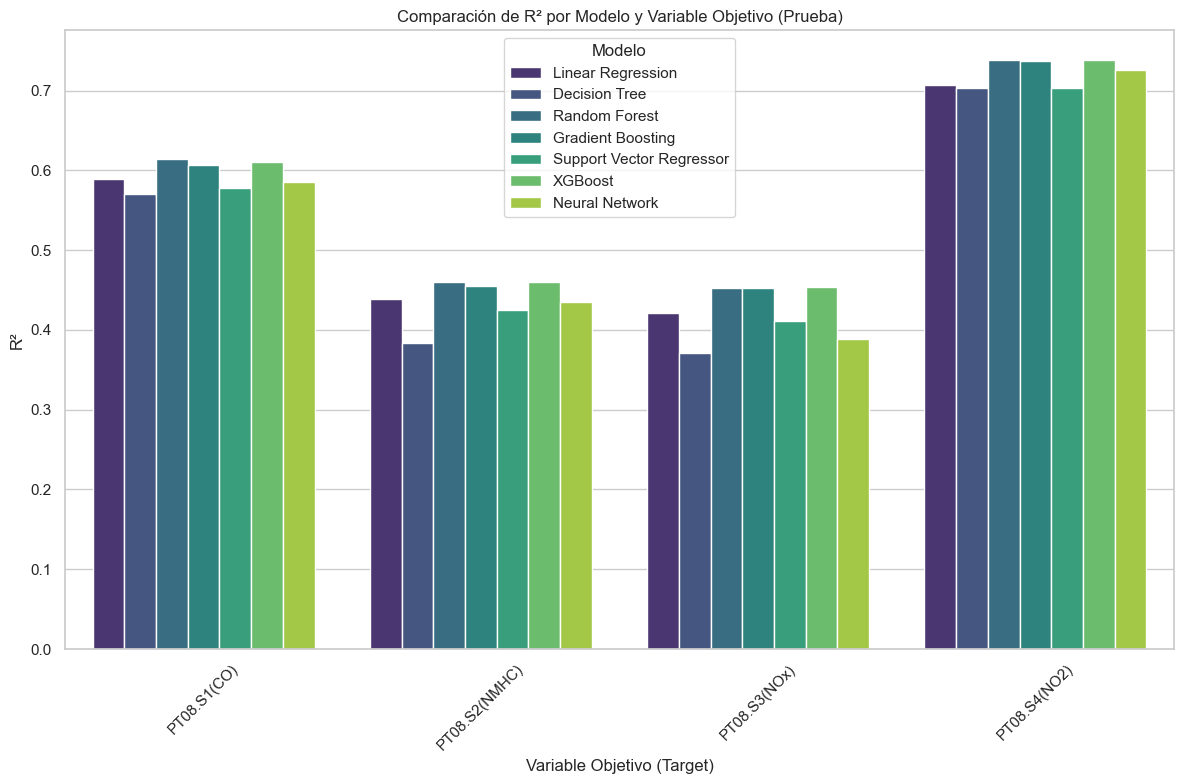

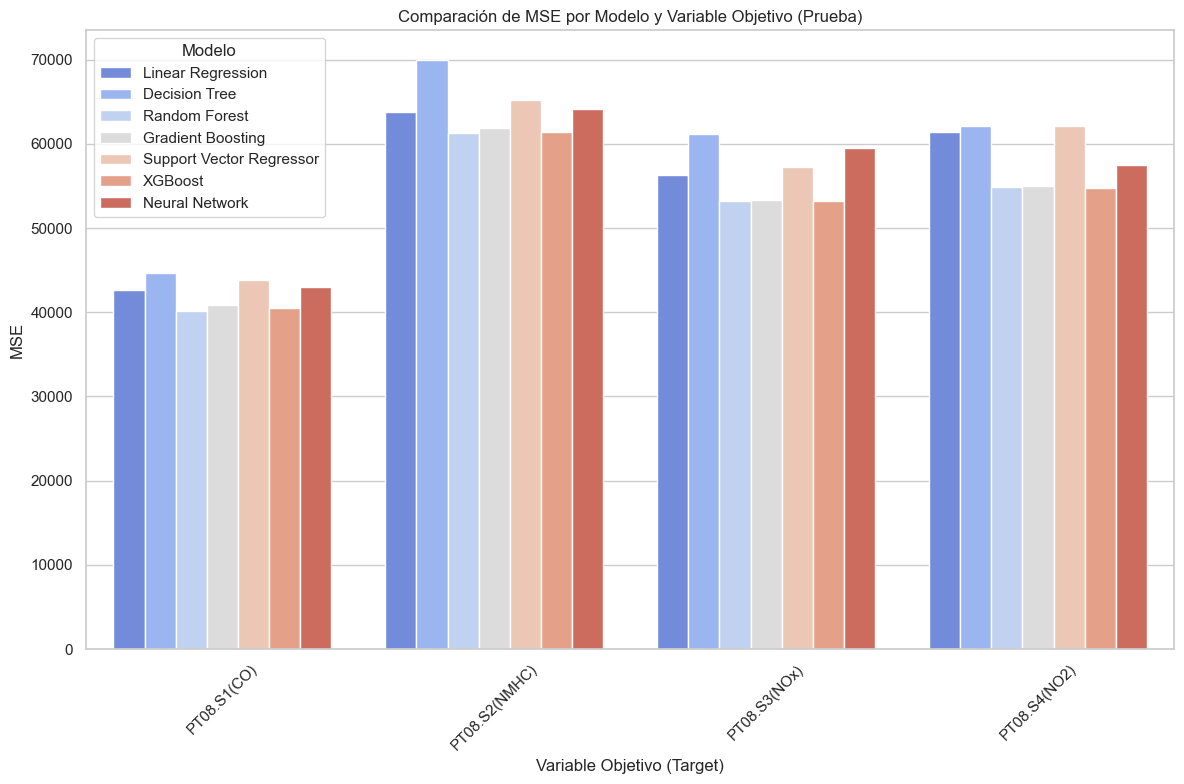

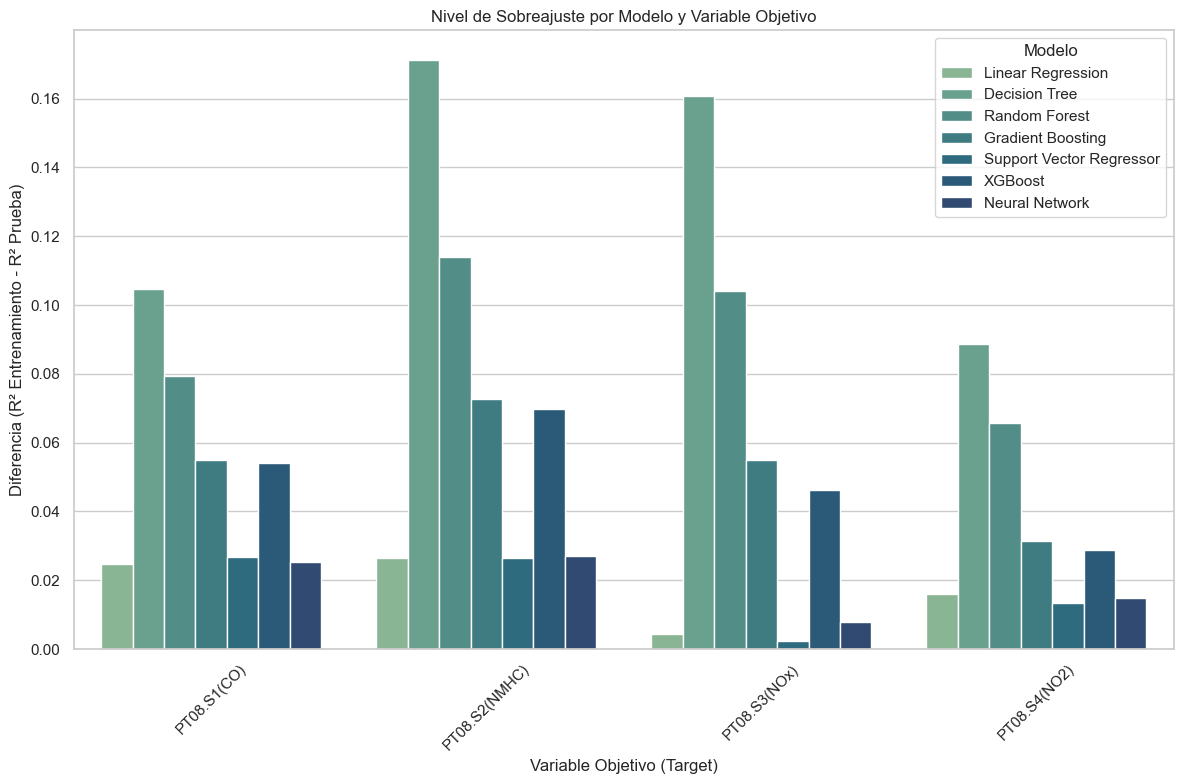

In [ ]:

# Convertir los resultados en un DataFrame para facilitar la visualización
rows = []
for target, metrics in results.items():
    for name, scores in metrics.items():
        rows.append({
            'Target': target,
            'Model': name,
            'MSE Train': scores['Metrics Train']['MSE'],
            'MSE Test': scores['Metrics Test']['MSE'],
            'MAE Train': scores['Metrics Train']['MAE'],
            'MAE Test': scores['Metrics Test']['MAE'],
            'R2 Train': scores['Metrics Train']['R²'],
            'R2 Test': scores['Metrics Test']['R²'],  # R2 de prueba
            'Overfitting': scores['Metrics Train']['R²'] - scores['Metrics Test']['R²'],  # Calcular sobreajuste
            'Best Params': scores['Best Params']
        })

results_df = pd.DataFrame(rows)

# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Gráfico de R² (entrenamiento vs prueba)
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='R2 Test', hue='Model', palette='viridis')
plt.title("Comparación de R² por Modelo y Variable Objetivo (Prueba)")
plt.ylabel("R²")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de MSE (entrenamiento vs prueba)
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='MSE Test', hue='Model', palette='coolwarm')
plt.title("Comparación de MSE por Modelo y Contaminante")
plt.ylabel("MSE")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de sobreajuste
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='Overfitting', hue='Model', palette='crest')
plt.title("Nivel de Sobreajuste por Modelo y Contaminante")
plt.ylabel("Diferencia (R² Entrenamiento - R² Prueba)")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Conclusión final**

el método Z-score porque es más adecuado para evaluar todo el conjunto de datos, más flexible al ajustar el umbral y posiblemente porque tus datos tienen características estadísticas que favorecen este enfoque. 

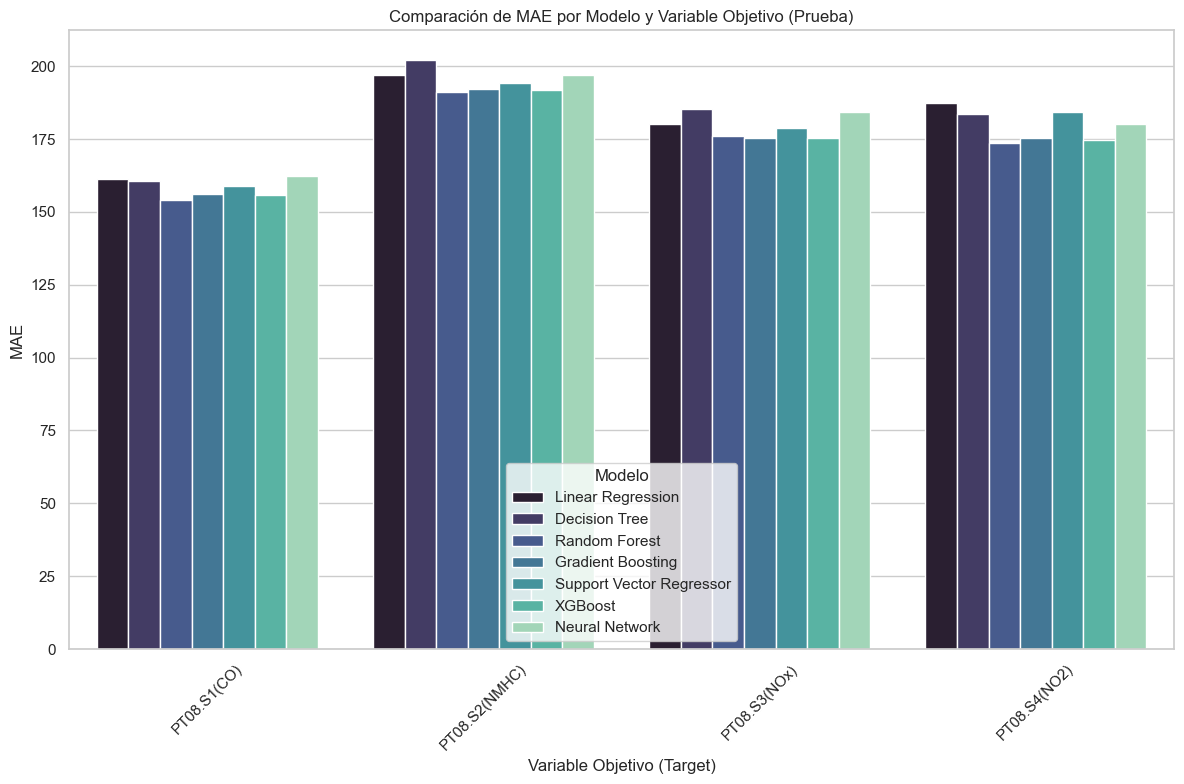

In [13]:
# Gráfico de MAE (entrenamiento vs prueba)
plt.figure(figsize=(12, 8))
sns.barplot(data=results_df, x='Target', y='MAE Test', hue='Model', palette='mako')
plt.title("Comparación de MAE por Modelo y Variable Objetivo (Prueba)")
plt.ylabel("MAE")
plt.xlabel("Variable Objetivo (Target)")
plt.legend(title="Modelo")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


PARTE DE MIA IMANOL

In [ ]:
import joblib

# Cargar el modelo en Python 3
model = joblib.load('modelo_xgb_optimizado.pkl')

# Guardarlo nuevamente en un formato compatible con Python 2 (protocolo 2)
joblib.dump(model, 'modelo_xgb_optimizado_v2.pkl', protocol=2)

['modelo_xgb_optimizado_v2.pkl']